# Spectral energy density

In this example we will study the spectral energy density of a crystal.

The simple spectral energy density (SED) method for crystals is implemented in dynasor as a complement to the auto-correlation functions (ACF).
In this method the information about the crystal structure is included in the analysis.
The method is very similar to the velocity auto-correlation method (VACF).
The results from SED typically converge comparably fast and features of interest are sometimes more visible.
The drawback is that it only works for perfect crystals.

This example will demonstrate how to compare the dispersion as obtained from zero Kelvin lattice dynamics theory using [phonopy](https://phonopy.github.io/phonopy/) with the fully anharmonic molecular dynamic (MD) simulations using [GPUMD](https://gpumd.org/). Some theoretical background can be found in the [theory section of the documentation](https://dynasor.materialsmodeling.org/theory.html#spectral-energy-density-sed-method).

dynasor supplies a function to calculate the spectrum at any given q-point.
In practice any q-point can be supplied but due to aliasing, spurious frequencies will arise at q-points which are not at the exact inverse supercell lattice.
For simple diagonal repetitions it is easy to find these points.
The difficulty arises when the supercell is not a simple repetition of the primitive cell.
To aid in these type of situations dynasor provides some helper functions.

1. The `Lattice` object is a map between the primitive cell and the supercell
2. The `make_path` method returns exact, commensurate q-points along a given path in the Brillouine zone.

In the following example graphite is used since the 2D character makes it easy to visualize the concepts in the x-y/a-b plane.

Note that although this example uses ase, [calorine](https://calorine.materialsmodeling.org/), gpumd and phonopy none of these are strictly needed.

## Setup and visualization of structures
We can use `ase` to read the graphite primitive structure located in the example directory.

In [2]:
from ase.io import read

prim = read('graphite.xyz')
print(prim)

Atoms(symbols='C4', pbc=True, cell=[[2.46748, 0.0, 0.0], [1.23374, 2.1369, 0.0], [0.0, 0.0, 6.554959]])


As we can see the cell vectors are pointing in the x-direction and at a 60 degree angle as we expect.
To make things a bit more challenging we will instead of the hexagonal primitive cell use an orthorhombic unitcell.

In [3]:
unitcell = prim.copy()
unitcell = unitcell.repeat((1,2,1))  # repeat cell along b-axis
cell = unitcell.cell
cell[1] -= cell[0]  # remove one unit of a-axis from b-axis
unitcell.set_cell(cell)
unitcell.wrap()
print(unitcell)

Atoms(symbols='C8', pbc=True, cell=[2.46748, 4.2738, 6.554959])


As we can see the cell is now orthorhombic. ase provides a simple tool to visualize atomic structures with `ase.visualize.view(prim)`.

Lastly we can construct a larger supercell suitable for molecular dynamics simulations

In [5]:
dim = (6, 6, 2)
supercell = unitcell.repeat(dim)
print(supercell)

Atoms(symbols='C576', pbc=True, cell=[14.80488, 25.642799999999998, 13.109918])


Now let's visualize these structures using matplotlib. 

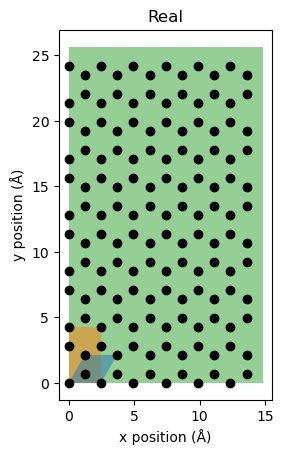

In [6]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ax.set_title('Real')
ax.set_xlabel('x position (Å)')
ax.set_ylabel('y position (Å)')
ax.set_aspect('equal')

# Finds corners of cell
make_box = lambda cell:([[0,0],[1,0],[1,1],[0,1],[0,0]] @ cell).T

x, y = make_box(supercell.cell[:2, :2])
ax.fill(x, y, facecolor='tab:green', alpha=0.5)

x, y = make_box(unitcell.cell[:2, :2])
ax.fill(x, y, facecolor='tab:orange', alpha=0.5)

x, y = make_box(prim.cell[:2, :2])
ax.fill(x, y, facecolor='tab:blue', alpha=0.5)

# plot the atoms in the bottom graphene layer as black dots
x, y, z = supercell.positions.T
bottom_layer = np.isclose(z, z.min())
x, y = x[bottom_layer], y[bottom_layer]
ax.plot(x, y, 'o', color='k')


The above figure is aspect true so we can see the perfect honeycomb pattern of the bottom most graphene layer.
The blue cell indicate the primitive cell, the orange cell indicate the unitcell and the green cell indicate the supercell.

## Phonopy calculations
Next we'll use phonopy and calorine to generate the phonon dispersion of graphite.
First we'll use calorine to set up an ase calculator.
The potential can be downloaded from

https://zenodo.org/record/7811021/files/nep-C-CX.txt

In [7]:
from calorine.calculators import CPUNEP
from urllib.request import urlretrieve

link = 'https://zenodo.org/record/7811021/files/nep-C-CX.txt'
urlretrieve(link)

pot_name = link.split('/')[-1]
calc = CPUNEP(pot_name)
prim.calc = calc

Next we use calorine to set up the `phonon` object.
Note that we will use the same dimensions as the supercell but in principle as long as the there are no periodic image interactions any dimension can be used.

In [8]:
from calorine.tools import get_force_constants, relax_structure

phonon = get_force_constants(prim, calc, [6, 6, 2])

We are now ready to generate the dispersion.
We will generate our own path in the Brilloine zone.
Remember that the coordinates corresponds to scaled positions of the inverse primitive cell.
E.g. `(1/2, 0, 0)` would correspond to a wave at the Brilloine zone boundary traveling in the direction perpendicular to the `b` and `c` axes of the real cell.

In [9]:
path = 'AGMKG'
special_points = dict(
    A = [0,   0,   1/2],
    G = [0,   0,   0  ],  # Gamma point
    M = [0,   1/2, 0  ],
    K = [1/3, 2/3, 0  ])

path_list = []
for start, stop in zip(path[:-1], path[1:]):
    start = special_points[start]
    stop = special_points[stop]
    path_list.append(np.linspace(start, stop, 100))

phonon.run_band_structure(path_list)
phonopy_paths, phonopy_dists, phonopy_freqs, *_ = phonon.get_band_structure()

We are now ready to plot the dispersion from phonopy.

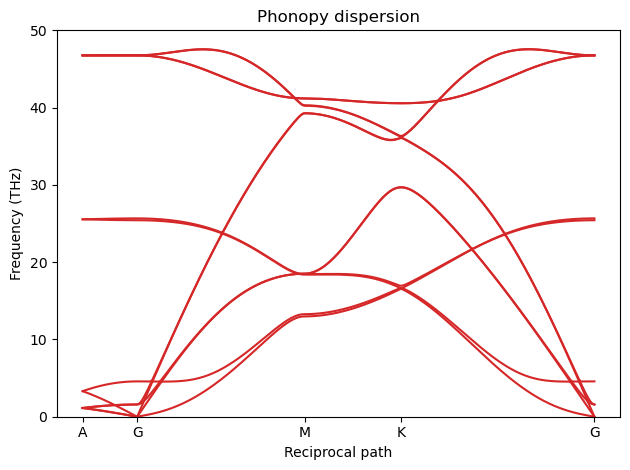

In [10]:
fig_phonopy_dispersion, ax = plt.subplots()
ax.set_title('Phonopy dispersion')
ax.set_xlabel('Reciprocal path')
ax.set_ylabel('Frequency (THz)')

xticks = [d[0] for d in phonopy_dists] + [phonopy_dists[-1][-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(list(path))

ax.plot(np.hstack(phonopy_dists), np.vstack(phonopy_freqs), color='tab:red')

ylim = 0, 50
ax.set_ylim(ylim)

fig_phonopy_dispersion.tight_layout()

Now we want to create the same dispersion using MD.
The problem is that not all of the q-points in the above dispersion are supported by our choice of supercell.
All points between are in some sense interpolated.
q-points at exact inverse supercell lattice points are always exact and points between are exact only if the force constants decay to zero within the supercell (a.k.a. the L/2 criterion).

dynasor supplies two helper functions to find these exact q-points.
The `Lattice` object represents the map between the primitive cell and the supercell.
It will provide us with the `P` matrix.
The `make_path` can find exact points along a straight path in the Brillouine zone.
It return those points and fractional distances along the path.


In [11]:
# get qpoints
from dynasor.qpoints.lattice import Lattice

lat = Lattice(prim.cell, supercell.cell)

dyna_paths, dyna_dists = [], []
for p, d in zip(phonopy_paths, phonopy_dists):
    p0, p1 = p[[0, -1]]
    
    dyna_path, dyna_dist = lat.make_path(p0, p1)
    dyna_paths.append(dyna_path)
    
    d0, d1 = d[[0, -1]]
    dyna_dists.append(d0 + (d1 - d0) * dyna_dist)

We ca now update the dispersion with the exact q-points.

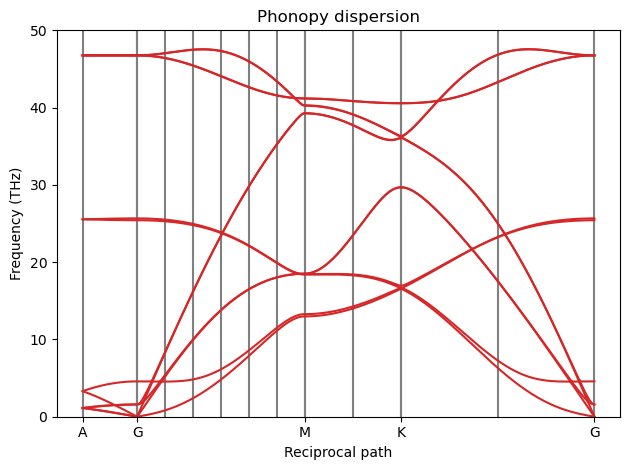

In [12]:
ax = fig_phonopy_dispersion.get_axes()[0]
ax.set_ylim(ylim)
ax.vlines(np.hstack(dyna_dists), *ylim, color='grey')
fig_phonopy_dispersion

To get a better feel for how the real and inverse/reciprocal cells realte we can plot them as we did for the real space.

First we need to convert our paths and inverse lattice points to cartesian coordinates.

In [13]:
qpoints_supercell = lat.qpoints

phonopy_path = lat.reduced_to_cartesian(np.vstack(phonopy_paths))

dynasor_path = np.vstack(dyna_paths)

Now lets plot them 

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Reciprocal')
ax.set_xlabel('x direction (1/Å)')
ax.set_ylabel('y direction (1/Å)')

# plot blue brillouine zone
ax.fill(*make_box(lat.reciprocal_primitive[:2, :2]), facecolor='tab:blue')

# plot red phonopy path
ax.plot(phonopy_path[:, 0], phonopy_path[:, 1], '-', color='tab:red')

# plot all supercell lattice points
ax.plot(qpoints_supercell[:, 0], qpoints_supercell[:, 1], 'o', color='tab:green')

# plot all points along path
ax.plot(dynasor_path[:, 0], dynasor_path[:, 1], 'o', color='tab:red')

# Annotate the special points
for label in path:
    lp = special_points[label]
    if not np.isclose(lp[2], 0):  # skip the A-point
        continue
    q = lat.reduced_to_cartesian(lp)
    ax.annotate(label, q[:2])

The blue cell are now the inverse primitive cell.
Notice how the reiprocal a-axis is perpendicular to the real b- and c-axes (the c-axis are towards us with the A point above the gamma point G).
The green dots indicate all q-points which are spanned by our supercell.
They represent all supported waves and, as expected since the real supercell is shorter in the x/a direction, the inverse supercell lattice is sparser in that direction.
The red path is the infinite limit taken by phonopy and the red circles are the inverse supercell lattice points along this path.
Evidently as we change the supercell we can make the sampling denser or sparser or completely miss the special high-symmetry points.
It is also possible to make use of lattice symmetries to combine points from different but symmetrically equivalent paths to further increase the statistics and/or density of points along a path of interest.
Notice for example if we went along the symmetrically equivalent inverse a-axis we would only get two points instead of five points between the gamma point and the zone boundary.
On the other hand we would get three points for the (K-G) path instead of one.
This optimization is left as an excercise.

## Molecular dynamics simulations

We are now (finally) ready to make the dispersion using MD and the SED method.

We will use gpumd for this purpose and the first step is to write a suitable input file.
The most important parameter is the `dump` and `time_step` parameters.
They control the maximum frequency we can resolve in the simulation and should be higher than the max frequency in the dispersion.
gpumd uses femto-seconds as unit and with a dump frequency of once every 10 timesteps the maximum frequency is given by `0.5/(dt * dump)` Petahertz which is equal 50 Terahertz just above our maximum frequency from phonopy.

Don't forget to remove any old trajectories before starting a new simulation.

In [ ]:
import os
rundir = 'gpumd_run_dir'
os.system(f'rm -r {rundir}')

In [16]:
from calorine.calculators import GPUNEP

dt = 1
dump = 10
temp = 300
steps = 10**4

calc = GPUNEP(pot_name)
calc.set_directory(rundir)
supercell.calc = calc

parameters = [('time_step', dt),
              ('velocity', temp),
              ('ensemble', ('nvt_lan', temp, temp, 100)),
              ('run', steps//10),
              ('dump_exyz', (dump, 1, 0)),
              ('run', steps)]
calc.run_custom_md(parameters)

The SED function is simply invoked as follows. The ideal and primitive structures must be provided in order to correctly map atoms to primitive cells. Also notice that the q-points are given in angular units and the resulting frequency vector `w` is an angular frequency.

In [17]:
from dynasor import compute_spectral_energy_density
from dynasor import Trajectory
from ase import units

traj = Trajectory(f'{rundir}/dump.xyz', trajectory_format='extxyz')

w, sed = compute_spectral_energy_density(
        traj,
        ideal_supercell=supercell,
        primitive_cell=prim,
        q_points=dynasor_path,
        dt=dt*dump)


f = w * 1000 / (2*np.pi)  # radians/fs to cycles/ps (THz)

INFO: Trajectory file: gpumd_run_dir/dump.xyz
INFO: With a total of 576 particles, 1 types.
INFO: X: 576
INFO: Simulation cell is (nm):
[[1.480488  0.        0.       ]
 [0.        2.56428   0.       ]
 [0.        0.        1.3109918]]
INFO: Running SED
INFO: Setting time between consecutive frames (dt * step) to 10 fs.


Now we can plot the dispersion along phonopy's

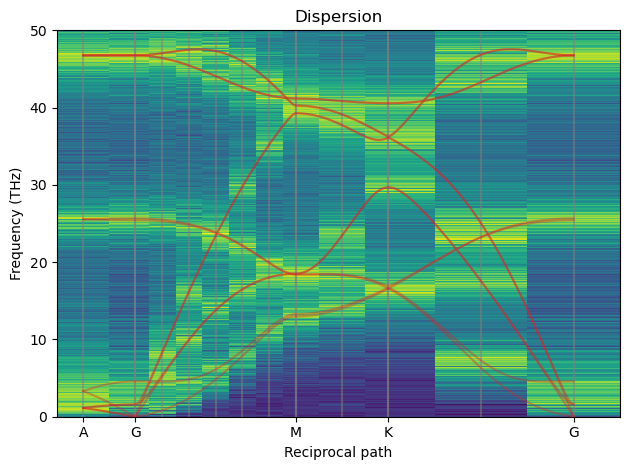

In [18]:
# Plot 
fig, ax = plt.subplots()
ax.set_title('Dispersion')
ax.set_xlabel('Reciprocal path')
ax.set_ylabel('Frequency (THz)')

# dynasor
ax.pcolormesh(np.hstack(dyna_dists), f, np.log(sed).T, shading='auto', rasterized=True)

#phonopy
ax.plot(np.hstack(phonopy_dists), np.vstack(phonopy_freqs), color='tab:red', alpha=0.4)

# exact points
ax.vlines(np.hstack(dyna_dists), 0, 50, color='grey', alpha=0.5)

ax.set_xticks(xticks)
ax.set_xticklabels(list(path))

ax.set_ylim(ylim)

fig.tight_layout()

The red line is the "exact" 0K phonopy dispersion.
The grey vertical lines are exact supercell inverse lattice points and the only consistent points to consider.
The vertical stripes are the results from SED and does only have meaning at the grey lines.
As we can see where the red and grey lines meet we have a high intensity from SED which is as expected.

Below is a dispersion for a 24x24x8 system at 900K simulated for 1ns

![dispersion-3.png](attachment:dispersion-3.png "24x24x8 ortho graphite at 900K simulated for 1ns")

It is also possible to plot slices at different q-points separately
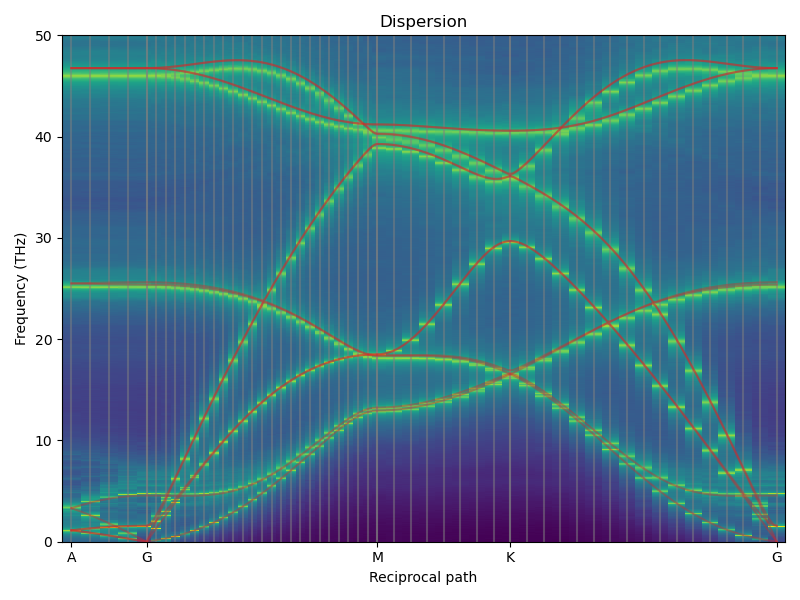

In [19]:
special_indices = np.cumsum([0] + [len(d) for d in dyna_dists])[:-1]
fig, ax = plt.subplots()

for label, spectrum in zip('AGMK', sed[special_indices]):
    ax.semilogy(f, spectrum, label=label)
ax.legend()
ax.set_xlim(0, 50)
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Spectral energy density (eV/Å⁻¹fs⁻¹?)')
fig.tight_layout()

Below is the equivalent converged spectra.

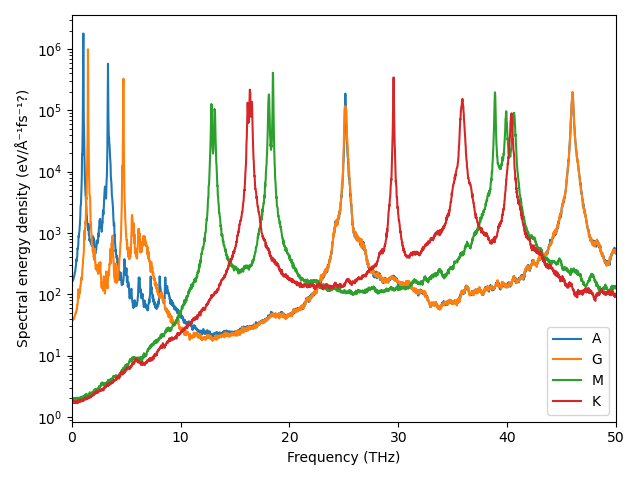